# 特征设计与模型训练

In [19]:
import pickle

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from utils import visualization_evaluation,visualization_y
%matplotlib inline

In [20]:
# some parameters
tran_size = 20000

blk_sz, sensitivity = 8, 32
selected_bands = [127, 201, 202, 294]
tree_num = 185
pic_row, pic_col= 600, 1024

dataset_file = f'./dataset/data_{blk_sz}x{blk_sz}_c{len(selected_bands)}_sen{sensitivity}_4.p'
model_file = f'./models/rf_{blk_sz}x{blk_sz}_c{len(selected_bands)}_{tree_num}_sen{sensitivity}_4.model'

## 数据集与样本平衡

In [21]:
# 读取数据
with open(dataset_file, 'rb') as f:
    x_list, y_list = pickle.load(f)
# 确保数据当中x和y数量对得上
assert len(x_list) == len(y_list)
print("数据量： ", len(x_list))
x, y = np.asarray(x_list), np.asarray(y_list, dtype=int)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=5,
                                                    shuffle=True, stratify=y)
print(f"x train {x_train.shape}, y train {y_train.shape}\n"
      f"x test {x_test.shape}, y test {y_test.shape}")

数据量：  19564
x train (13694, 8, 8, 4), y train (13694,)
x test (5870, 8, 8, 4), y test (5870,)


total (array([18474.,   762.,    75.,     0.,    62.,    91.,   100.]), array([0, 1, 2, 3, 4, 5, 6, 7]), <BarContainer object of 7 artists>) 
train (array([12931.,   533.,    53.,     0.,    43.,    64.,    70.]), array([0, 1, 2, 3, 4, 5, 6, 7]), <BarContainer object of 7 artists>) 
test (array([5543.,  229.,   22.,    0.,   19.,   27.,   30.]), array([0, 1, 2, 3, 4, 5, 6, 7]), <BarContainer object of 7 artists>)


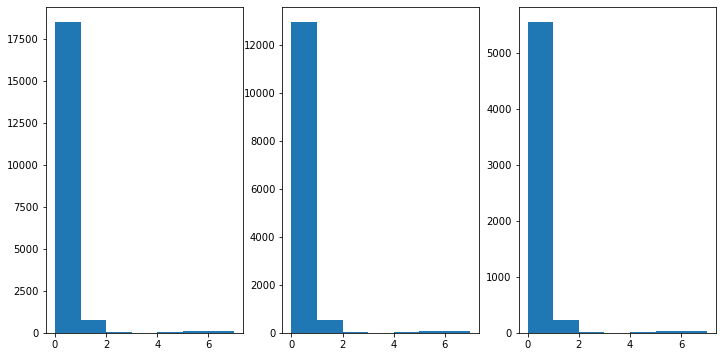

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
hist_res_total = axs[0].hist(y,[0, 1, 2, 3, 4, 5, 6, 7], align='mid')
hist_res_train = axs[1].hist(y_train,[0, 1, 2, 3, 4, 5, 6, 7], align='mid')
hist_res_test = axs[2].hist(y_test,[0, 1, 2, 3, 4, 5, 6, 7], align='mid')
print(f'total {hist_res_total} \n'
      f'train {hist_res_train} \n'
      f'test {hist_res_test}')
plt.show()

train (array([12931., 12931., 12931.,     0., 12931., 12931., 12931.]), array([0, 1, 2, 3, 4, 5, 6, 7]), <BarContainer object of 7 artists>) 



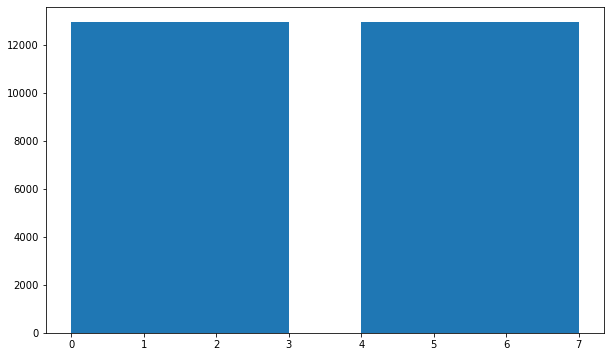

train (array([3333., 3333., 3334.,    0., 3333., 3333., 3334.]), array([0, 1, 2, 3, 4, 5, 6, 7]), <BarContainer object of 7 artists>) 



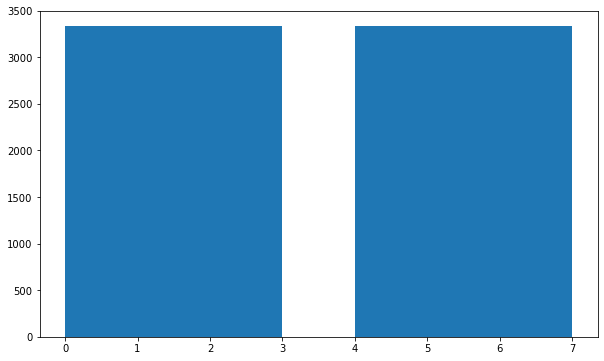

20000


In [23]:
# 发现样本实在是不平衡
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
x_train_shape = x_train.shape
x_train = x_train.reshape((x_train.shape[0], -1))
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
# 画图
fig, axs = plt.subplots(figsize=(10, 6))
hist_res_train = axs.hist(y_resampled, [0, 1, 2, 3, 4, 5, 6, 7], align='mid')
print(f'train {hist_res_train} \n')
plt.show()
# 抽样
x_train, _, y_train, _ =  train_test_split(x_resampled, y_resampled, train_size=tran_size, random_state=0,
                                           shuffle=True, stratify=y_resampled)
# 画图
fig, axs = plt.subplots(figsize=(10, 6))
hist_res_train = axs.hist(y_train, [0, 1, 2, 3, 4, 5, 6, 7], align='mid')
print(f'train {hist_res_train} \n')
plt.show()
x_train = x_train.reshape(x_train.shape[0], x_train_shape[1], x_train_shape[2], x_train_shape[3])
print(len(x_train))

## 特征设计
设计特征

In [24]:
from models import feature

In [25]:
features_train = feature(x_train)
features_test = feature(x_test)
print(features_test.shape)

(5870, 256)


## 进行训练，验证特征好坏

In [26]:
from models import train_rf_and_report, SpecDetector
feature_x = feature(x)
clf = train_rf_and_report(features_train, y_train, feature_x, y, tree_num, save_path=model_file)

预测时间： 0.2433488368988037
RFC训练模型评分：1.0
RFC待测模型评分：0.977918626047843
RFC预测结果：[0 0 0 ... 1 5 5]
---------------------------------------------------------------------------------------------------
RFC分类报告
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     18474
           1       0.68      0.99      0.80       762
           2       0.79      0.85      0.82        75
           4       0.85      0.81      0.83        62
           5       0.82      0.84      0.83        91
           6       0.82      0.97      0.89       100

    accuracy                           0.98     19564
   macro avg       0.82      0.91      0.86     19564
weighted avg       0.98      0.98      0.98     19564

RFC混淆矩阵：
[[18092   343     9     3    15    12]
 [    5   753     3     1     0     0]
 [    0     1    64     5     1     4]
 [    1     9     2    50     0     0]
 [    0     8     1     0    76     6]
 [    0     0     2     0     1    97]]
rfc分类报告：
   

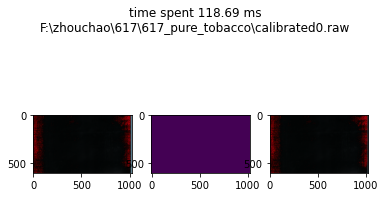

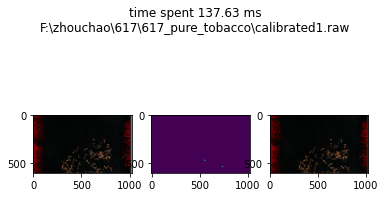

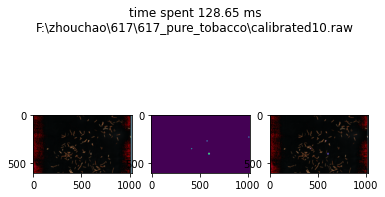

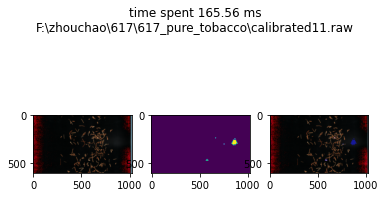

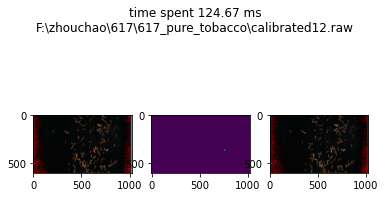

In [ ]:
model = SpecDetector(model_path=model_file, blk_sz=blk_sz, channel_num=len(selected_bands))
# 画图验证效果
visualization_evaluation(detector=model, data_path=r'F:\zhouchao\617\617_pure_tobacco', selected_bands=selected_bands)

In [ ]:
visualization_y(y_list, blk_sz)